In [1]:
# importing libraries 
import numpy as np 
import copy 
import cv2 as cv 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [2]:
def visualizeImgs(nrows, ncols, imgs, titles, figsize): 
    fig, ax = plt.subplots(nrows, ncols, figsize = figsize) 
    ax = ax.reshape((nrows*ncols, )); i = 0
    for row in range(nrows): 
        for col in range(ncols): 
            imgRGB = cv.cvtColor(imgs[i], cv.COLOR_BGR2RGB) 
            ax[i].imshow(imgRGB) 
            ax[i].axis('off') 
            if not titles == None: ax[i].set_title(titles[i]) 
            i += 1 

In [3]:
def blend(img1, img2, alpha = 0.5, beta = 0.5): 
    "blends only the non-zero regions of the given two images" 
    # creating a zero mask 
    mask = np.zeros(img2.shape[:2]) 

    # replacing color pixels in img2 by 1s in the mask 
    B2, G2, R2 = img2[:,:,0], img2[:,:,1], img2[:,:,2] # seperating the layers in img2 
    color = B2 + G2 + R2 
    mask[color != 0] = 1 
    mask = mask.astype(np.uint8) 

    # cutting img1 using the obtained mask 
    img1_ = copy.deepcopy(img1)
    B1, R1, G1 = img1_[:,:,0], img1_[:,:,1], img1_[:,:,2] 
    B1 *= mask; R1 *= mask; G1 *= mask 
    cutIn = cv.merge((B1, R1, G1)) 
    cutOut = img1 - cutIn 

    # performing blending 
    blended = cutOut + cv.addWeighted(cutIn, alpha, img2, beta, 0.0)
    return blended 

In [4]:
def drawTetragon(event, x, y, flags, param): 
    "draws a tetragon connecting 4 points given by mouse left-clicks"
    if event == cv.EVENT_LBUTTONDOWN and len(tetragonVertices) < 4: 
        point = (x, y)
        tetragonVertices.append(point) 
        cv.circle(img1_copy, point, 4, (0, 0, 255), -1) 
        if len(tetragonVertices) > 1: cv.line(img1_copy, tetragonVertices[-2], point, (0, 0, 255), 2)
        if len(tetragonVertices) == 4: cv.line(img1_copy, point, tetragonVertices[0], (0, 0, 255), 2) 

def leastSquareHomography(matches): 
    "computes the homography between two images using the Least Square method"
    if not len(matches) >= 4: print("Error - not enough matches to determine a homography") 
    A = np.zeros((1, 9)) # initialize a dummy array with all zeros D 
    for i in range(len(matches)): 
        (x1, y1), (x2, y2) = matches[i]
        row1 = np.array([x1, y1,  1,  0,  0,  0, -x2*x1, -x2*y1, -x2]).astype(np.float64) 
        row2 = np.array([ 0,  0,  0, x1, y1,  1, -y2*x1, -y2*y1, -y2]).astype(np.float64) 
        A = np.vstack((A, row1)) 
        A = np.vstack((A, row2)) 
    A = A[1: ] # removing the dummy zero array from the top 
    # the homography Matrix H can be obtained from the eigen vector of (A.T @ A) that corresponds to the smallest eigen value. 
    evalues, evectors = np.linalg.eig(np.dot(A.T, A)) 
    i_min = min(range(len(evalues)), key = lambda i: evalues[i]) 
    h = evectors[:, i_min] 
    H = h.reshape((3, 3)) 
    return H 

def warpAndBlend(Img1, Img2, alpha, beta): 
    "warp img2 on img1 over a rectangular region drawn on the img1" 
    global tetragonVertices, img1_copy  

    # opening the images 
    img1 = cv.imread(Img1, cv.IMREAD_ANYCOLOR); assert img1 is not None; img1_copy = copy.deepcopy(img1)
    img2 = cv.imread(Img2, cv.IMREAD_ANYCOLOR); assert img2 is not None

    # drawing the tetragon region for warping img2 on img1 
    cv.namedWindow("image", cv.WINDOW_AUTOSIZE) 
    tetragonVertices = []
    cv.setMouseCallback("image", drawTetragon) 
    while True: 
        cv.imshow("image", img1_copy) 
        if cv.waitKey(20) != -1: break  
    cv.destroyAllWindows() 

    # finding the corner points of img2 
    y2, x2 = img2.shape[:2] 
    img2Vertices = [(0, 0), (x2, 0), (x2, y2), (0, y2)] 

    # finding the homography from img2 to the tetragon drawn on img1 
    matches = [(img2Vertices[i], tetragonVertices[i]) for i in range(4)] 
    H = leastSquareHomography(matches) 

    # Warp img2 on img1 using the found homography and blend the images
    height, width = img1.shape[:2] 
    img1onto1 = cv.warpPerspective(img1, np.identity(3), (width, height))  
    img2onto1 = cv.warpPerspective(img2,              H, (width, height)) 
    img2blendedOn1 = blend(img1onto1, img2onto1, alpha, beta) 

    return img1, img2, img2blendedOn1 

In [77]:
im = cv.imread("Olympic/2020 olympics.jpg", cv.IMREAD_ANYCOLOR) 
out = cv.resize(im, None, fx = 0.5, fy = 0.5, interpolation = cv.INTER_AREA) 
cv.imshow("image", im) 
cv.waitKey(0) 
cv.imshow("image_", out) 
cv.waitKey(0) 
cv.destroyAllWindows() 
cv.imwrite("Olympic/2020 olympics.jpg", out) 

True

In [5]:
im1, im2, im3 = warpAndBlend("University of Oxford/002.jpg", "University of Oxford/university-of-oxford-logo.png", 0.4, 0.6) 
im4, im5, im6 = warpAndBlend("Olympic/swimming pool 3.jpg", "Olympic/olympic flag.png", 0.5, 0.5) 

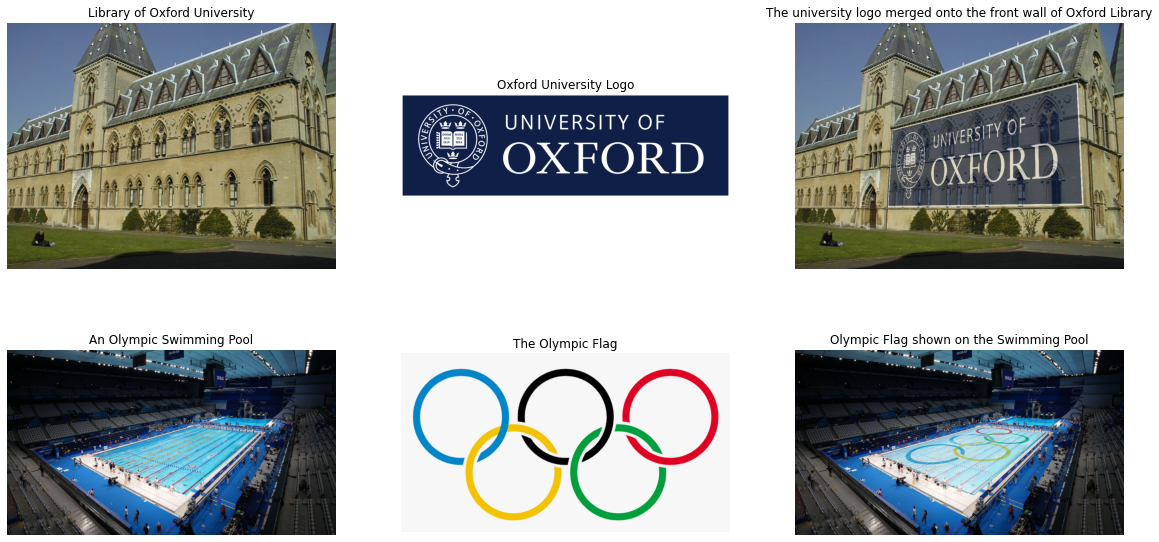

In [6]:
visualizeImgs(2, 3, (im1, im2, im3, im4, im5, im6), ("Library of Oxford University", "Oxford University Logo", 
"The university logo merged onto the front wall of Oxford Library", "An Olympic Swimming Pool", "The Olympic Flag", "Olympic Flag shown on the Swimming Pool"), figsize = (20, 10))